# 原overfit_MLP文件的代码：

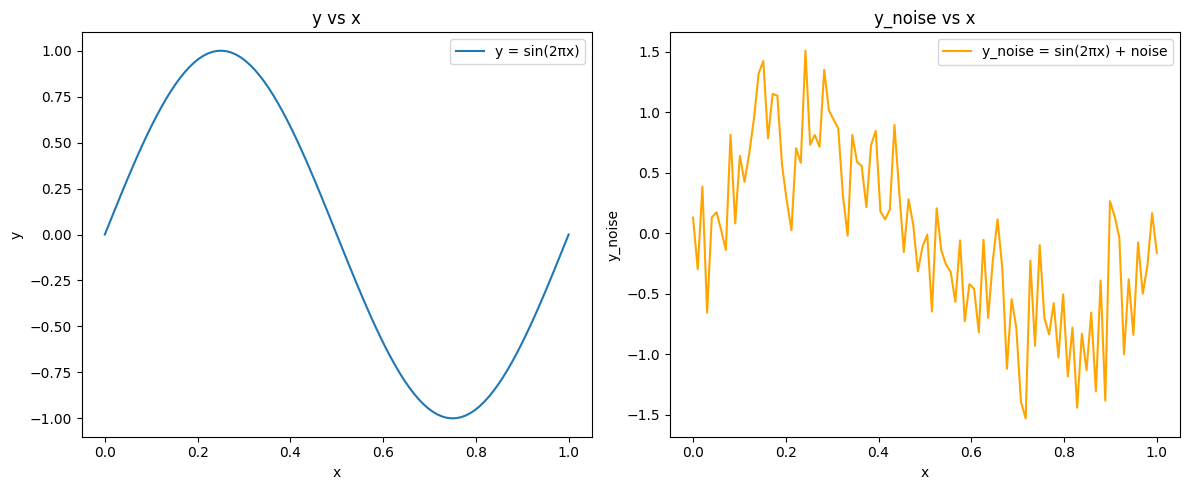

Epoch [100/1000], Loss: 0.2545
Epoch [200/1000], Loss: 0.2339
Epoch [300/1000], Loss: 0.2035
Epoch [400/1000], Loss: 0.1852
Epoch [500/1000], Loss: 0.1739
Epoch [600/1000], Loss: 0.1655
Epoch [700/1000], Loss: 0.1575
Epoch [800/1000], Loss: 0.1542
Epoch [900/1000], Loss: 0.1512
Epoch [1000/1000], Loss: 0.1487


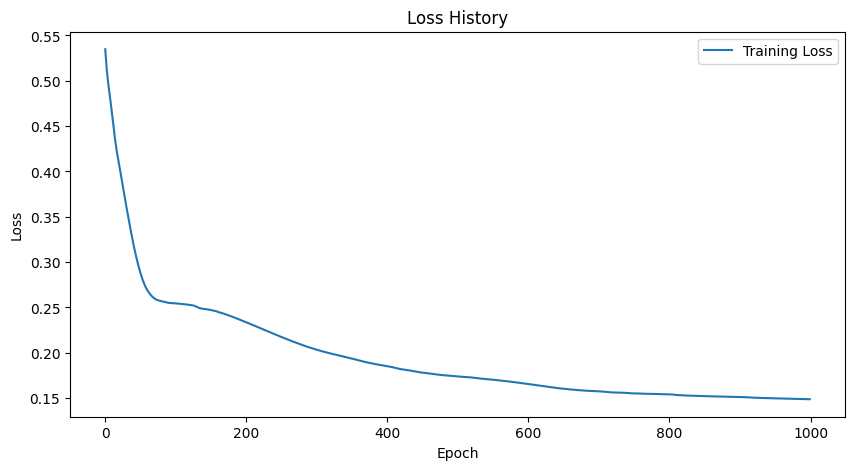

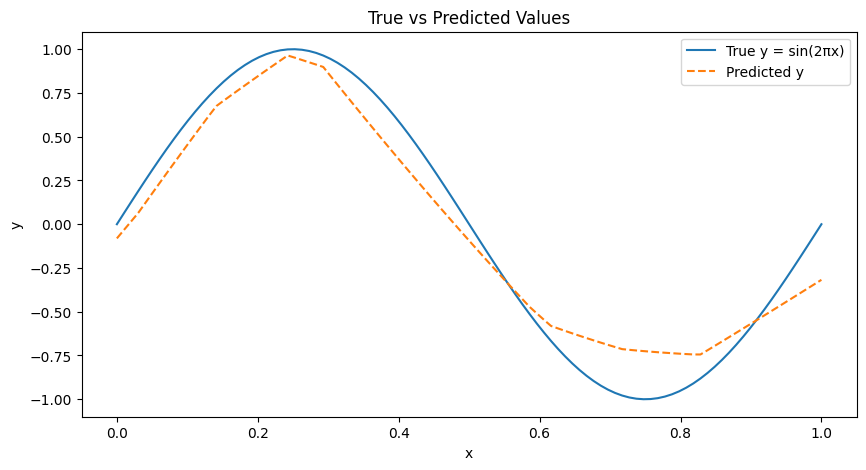

In [1]:
'''
A simple example of overfitting using a Multi-Layer Perceptron (MLP) to fit noisy sine wave data.
Author: Dongyang Kuang

NOTE: 
    [] Multiple aspects can be investigated:
'''

#%%
import numpy as np
import torch

def sin_2pi_on_grid(x):
    """
    Computes y = sin(2pi*x) on a uniform grid from 0 to 1.

    Parameters:
    x (int or array): input for evaluation.

    Returns:
    y (numpy.ndarray): The computed sine values at the grid points.
    """

    y = np.sin(2 * np.pi * x)  # what if include more periods in [0,1]
    return y

#%%
# Example usage:
num_points = 100 # Are there any sampling method that is more efficient?
x = np.linspace(0, 1, num_points) # what if non-uniform grid?
y = sin_2pi_on_grid(x)

# Add white noise to y
noise_intensity = 0.4
noise = np.random.normal(0, noise_intensity, len(y))
y_noise = y + noise

#%%
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot y vs x on the left subplot
axs[0].plot(x, y, label='y = sin(2πx)')
axs[0].set_title('y vs x')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].legend()

# Plot y_noise vs x on the right subplot
axs[1].plot(x, y_noise, label='y_noise = sin(2πx) + noise', color='orange')
axs[1].set_title('y_noise vs x')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y_noise')
axs[1].legend()

# Display the plots
plt.tight_layout()
plt.show()


#%%
import torch.nn as nn
import torch.optim as optim

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, hidden_units = 32):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(1, hidden_units) # what if I used different initialization?
        self.hidden2 = nn.Linear(hidden_units, hidden_units)
        self.output = nn.Linear(hidden_units, 1)
    
    def forward(self, x):
        x = torch.tanh(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        x = self.output(x)
        return x

#%%
# Prepare the data
USE_NOISE = True
x_tensor = torch.tensor(x, dtype=torch.float32).view(-1, 1)
if USE_NOISE:
    y_tensor = torch.tensor(y_noise, dtype=torch.float32).view(-1, 1)
else:
    y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

#%%
# Initialize the model, loss function, and optimizer
model = MLP(hidden_units = 32)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# Training loop
loss_history = []
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(x_tensor)
    loss = criterion(outputs, y_tensor)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    
# Plot the loss history
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Training Loss')
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model
model.eval()
with torch.no_grad():
    predicted = model(x_tensor).numpy()

#%%
# Plot the true values and the predicted values
plt.figure(figsize=(10, 5))
plt.plot(x, y, label='True y = sin(2πx)')
plt.plot(x, predicted, label='Predicted y', linestyle='--')
plt.title('True vs Predicted Values')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

# %%


# 1. 损失曲线三阶段现象分析


Epoch [500/3000], Loss: 0.2251, Clean Loss: 0.1561, Grad Norm: 0.0204
Epoch [1000/3000], Loss: 0.1214, Clean Loss: 0.0131, Grad Norm: 0.0460
Epoch [1500/3000], Loss: 0.1203, Clean Loss: 0.0119, Grad Norm: 0.0375
Epoch [2000/3000], Loss: 0.1194, Clean Loss: 0.0113, Grad Norm: 0.0541
Epoch [2500/3000], Loss: 0.1187, Clean Loss: 0.0114, Grad Norm: 0.0615
Epoch [3000/3000], Loss: 0.1184, Clean Loss: 0.0118, Grad Norm: 0.0940


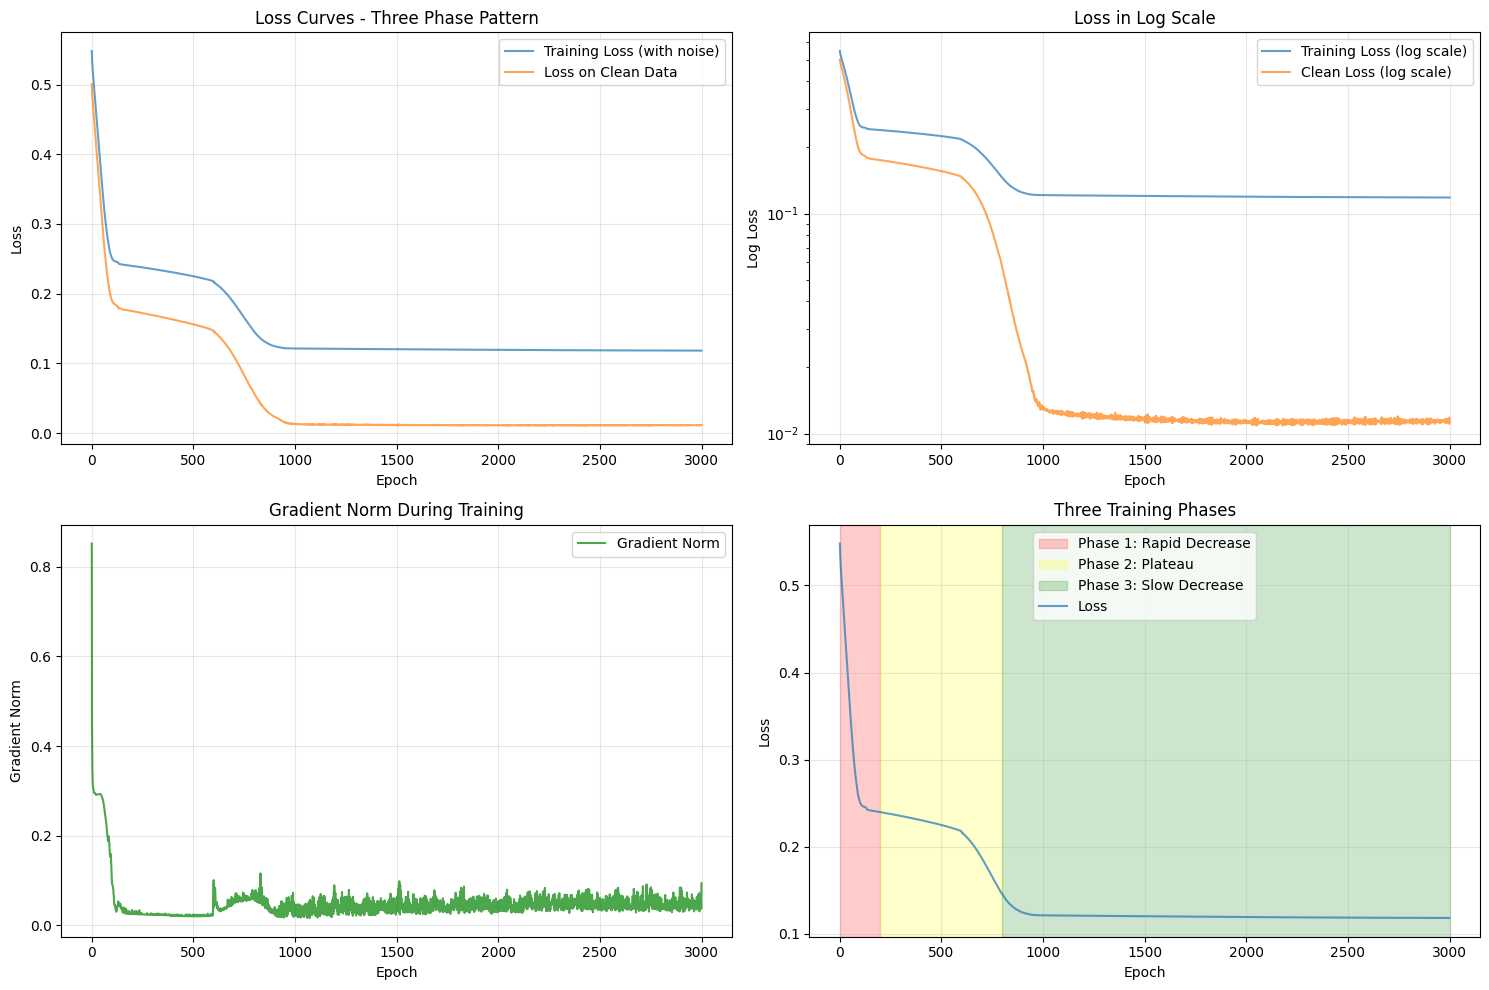

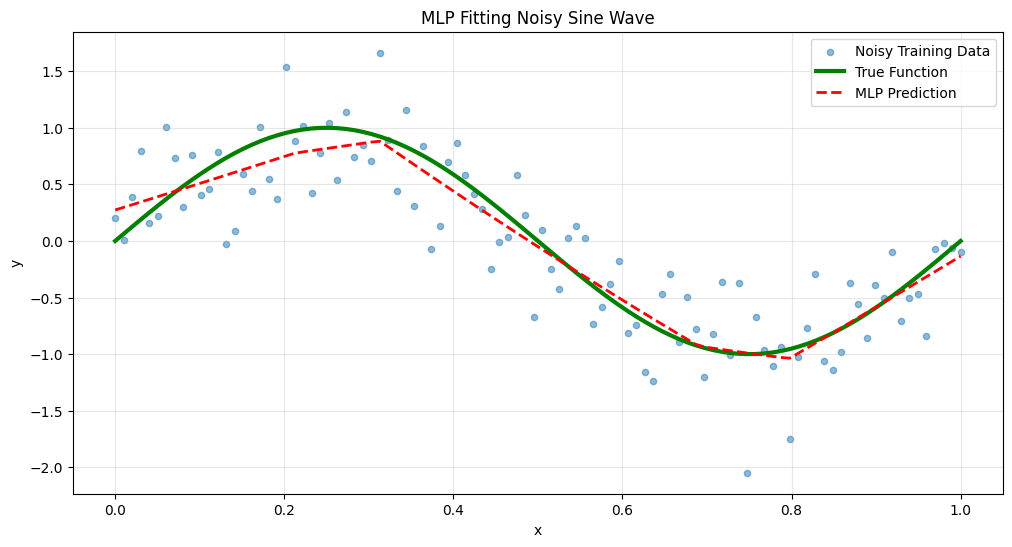

In [8]:
#%% 1. 损失曲线三阶段现象分析
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# 生成数据
np.random.seed(42)
torch.manual_seed(42)

num_points = 100
x = np.linspace(0, 1, num_points)
y_true = np.sin(2 * np.pi * x)
noise = np.random.normal(0, 0.4, len(y_true))
y_noisy = y_true + noise

# 转换为tensor
x_tensor = torch.tensor(x, dtype=torch.float32).view(-1, 1)
y_tensor = torch.tensor(y_noisy, dtype=torch.float32).view(-1, 1)
y_true_tensor = torch.tensor(y_true, dtype=torch.float32).view(-1, 1)

# 定义模型
class SimpleMLP(nn.Module):
    def __init__(self, hidden_units=32):
        super(SimpleMLP, self).__init__()
        self.hidden1 = nn.Linear(1, hidden_units)
        self.hidden2 = nn.Linear(hidden_units, hidden_units)
        self.output = nn.Linear(hidden_units, 1)
        nn.init.xavier_uniform_(self.hidden1.weight)
        nn.init.xavier_uniform_(self.hidden2.weight)
        nn.init.xavier_uniform_(self.output.weight)
    
    def forward(self, x):
        x = torch.tanh(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        x = self.output(x)
        return x

# 训练并记录梯度信息
model = SimpleMLP(hidden_units=32)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

num_epochs = 3000
loss_history = []
grad_norms = []
loss_without_noise = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(x_tensor)
    loss = criterion(outputs, y_tensor)
    loss.backward()
    
    # 计算梯度范数
    total_norm = 0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5
    grad_norms.append(total_norm)
    
    optimizer.step()
    loss_history.append(loss.item())
    
    # 计算在没有噪声的数据上的损失
    model.eval()
    with torch.no_grad():
        clean_outputs = model(x_tensor)
        clean_loss = criterion(clean_outputs, y_true_tensor).item()
        loss_without_noise.append(clean_loss)
    model.train()
    
    if (epoch+1) % 500 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Clean Loss: {clean_loss:.4f}, Grad Norm: {total_norm:.4f}')

# 绘制损失曲线和梯度范数
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 训练损失曲线
axes[0, 0].plot(loss_history, label='Training Loss (with noise)', alpha=0.7)
axes[0, 0].plot(loss_without_noise, label='Loss on Clean Data', alpha=0.7)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Loss Curves - Three Phase Pattern')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 对数坐标下的损失曲线
axes[0, 1].semilogy(loss_history, label='Training Loss (log scale)', alpha=0.7)
axes[0, 1].semilogy(loss_without_noise, label='Clean Loss (log scale)', alpha=0.7)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Log Loss')
axes[0, 1].set_title('Loss in Log Scale')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 梯度范数变化
axes[1, 0].plot(grad_norms, label='Gradient Norm', color='green', alpha=0.7)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Gradient Norm')
axes[1, 0].set_title('Gradient Norm During Training')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 学习率调整（可选）
axes[1, 1].axvspan(0, 200, alpha=0.2, color='red', label='Phase 1: Rapid Decrease')
axes[1, 1].axvspan(200, 800, alpha=0.2, color='yellow', label='Phase 2: Plateau')
axes[1, 1].axvspan(800, 3000, alpha=0.2, color='green', label='Phase 3: Slow Decrease')
axes[1, 1].plot(loss_history, label='Loss', alpha=0.7)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].set_title('Three Training Phases')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('three_phase_loss.png', dpi=150, bbox_inches='tight')
plt.show()

# 最终预测
model.eval()
with torch.no_grad():
    predicted = model(x_tensor).numpy()

plt.figure(figsize=(12, 6))
plt.scatter(x, y_noisy, alpha=0.5, label='Noisy Training Data', s=20)
plt.plot(x, y_true, 'g-', label='True Function', linewidth=3)
plt.plot(x, predicted, 'r--', label='MLP Prediction', linewidth=2)
plt.title('MLP Fitting Noisy Sine Wave')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('final_fit.png', dpi=150, bbox_inches='tight')
plt.show()


# 2. 不同噪声类型和强度的影响

Training on Gaussian_0.1...
Training on Uniform_0.1...
Training on Outliers_0.1...
Training on Heteroscedastic_0.1...
Training on Gaussian_0.2...
Training on Uniform_0.2...
Training on Outliers_0.2...
Training on Heteroscedastic_0.2...
Training on Gaussian_0.4...
Training on Uniform_0.4...
Training on Outliers_0.4...
Training on Heteroscedastic_0.4...
Training on Gaussian_0.8...
Training on Uniform_0.8...
Training on Outliers_0.8...
Training on Heteroscedastic_0.8...


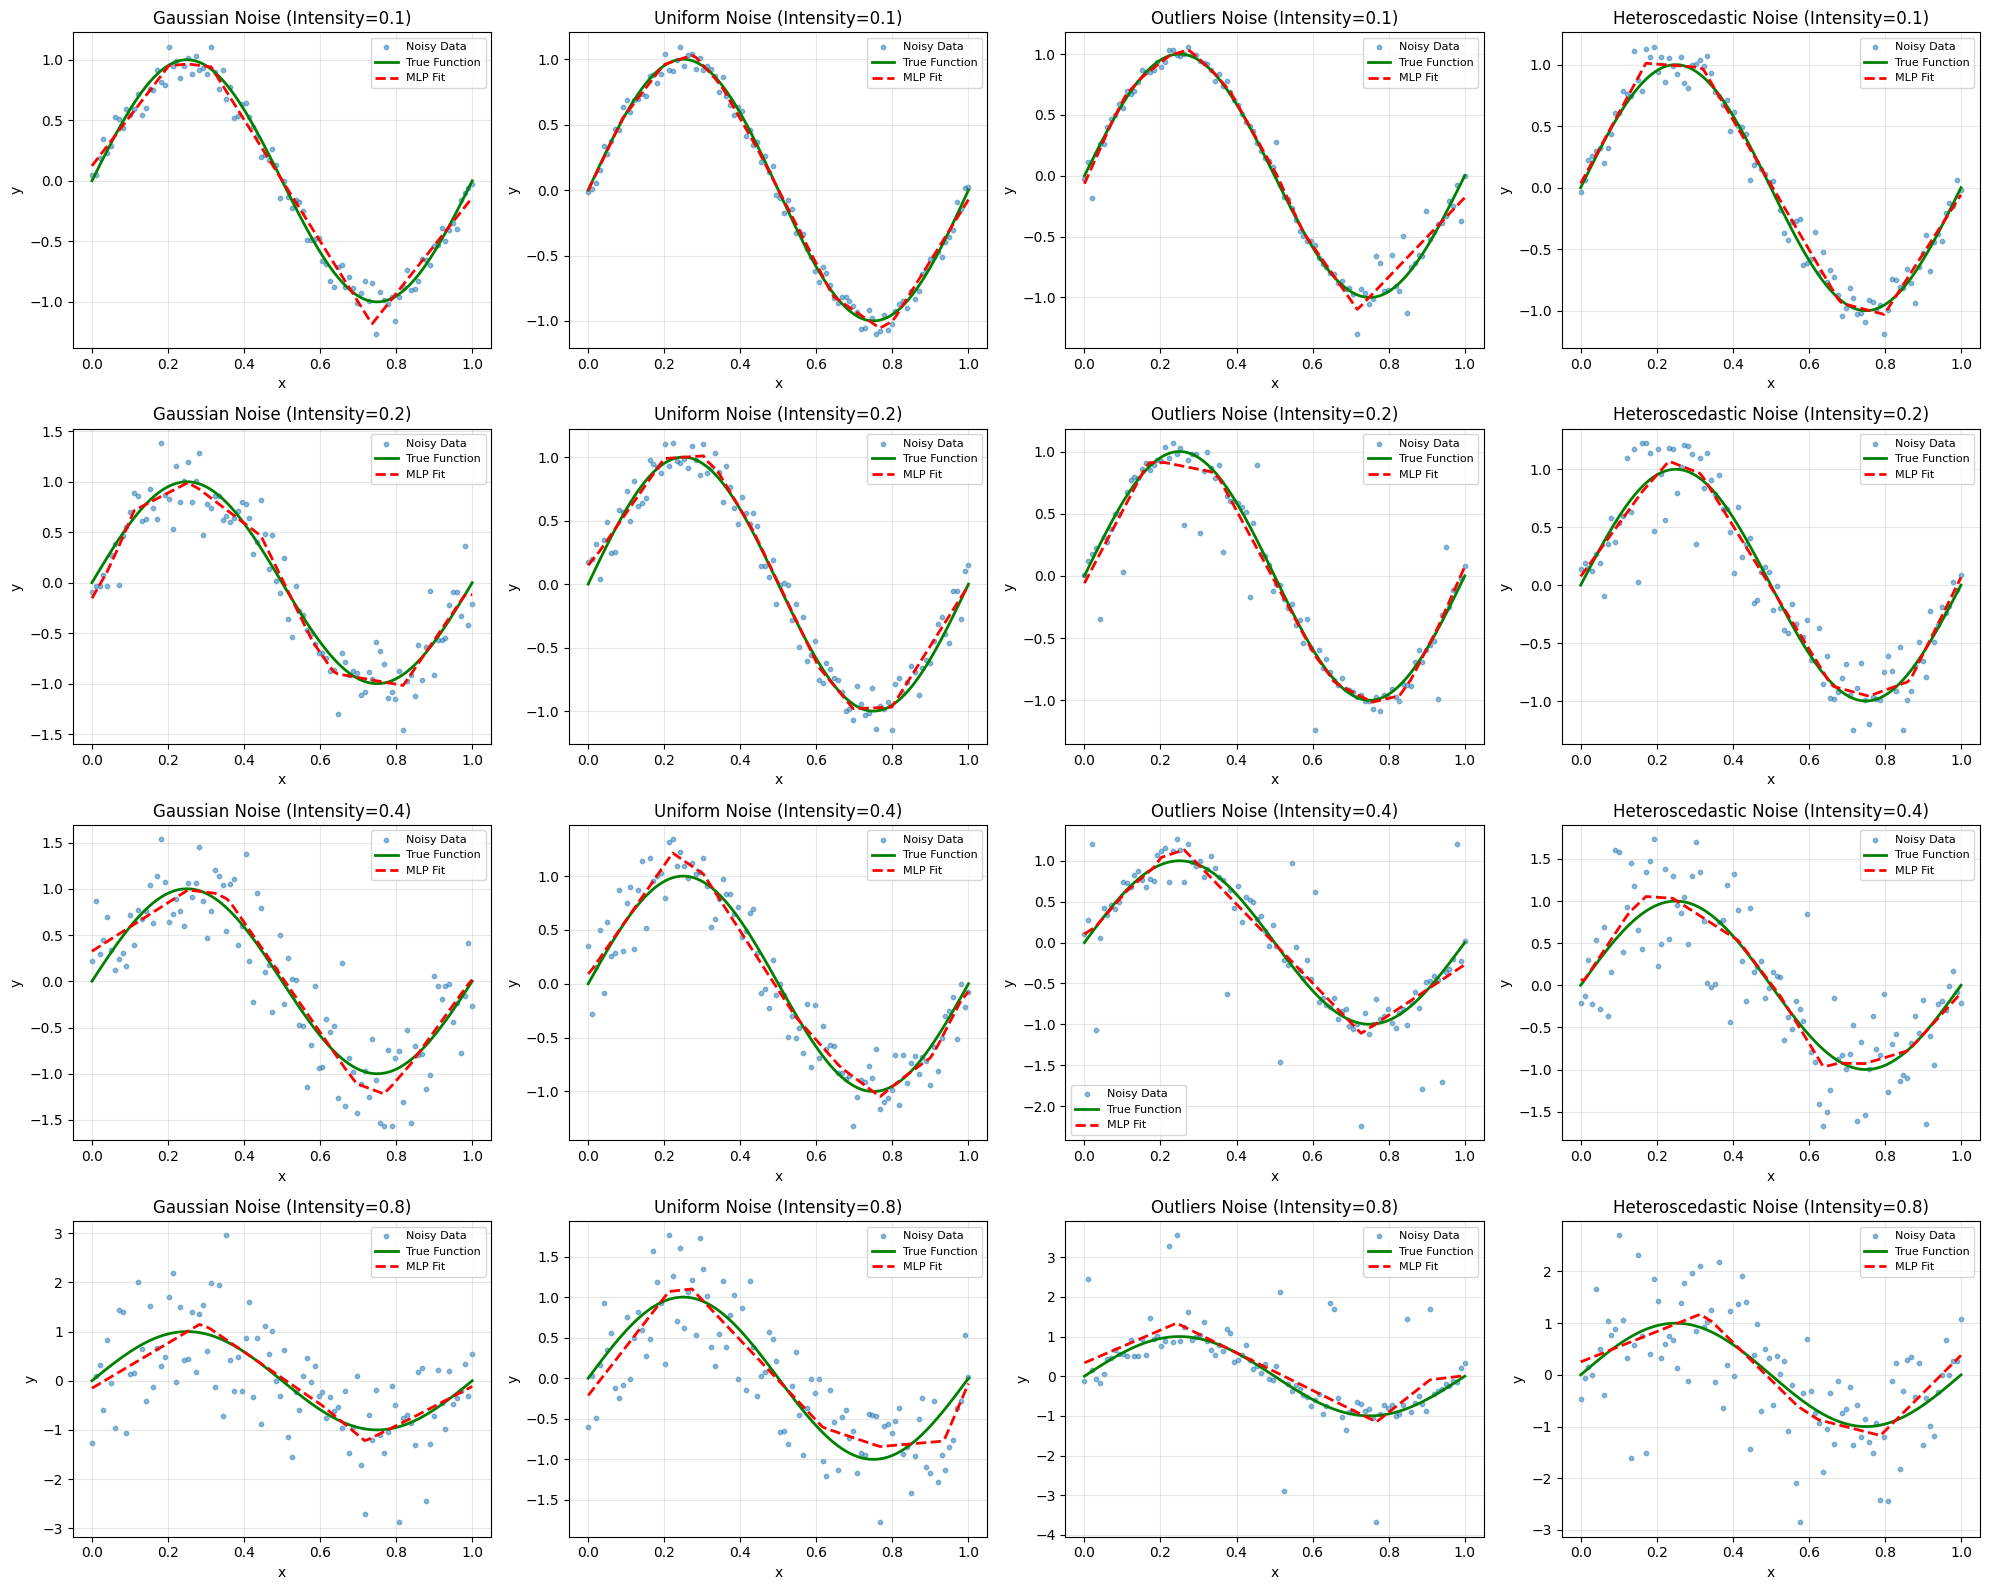

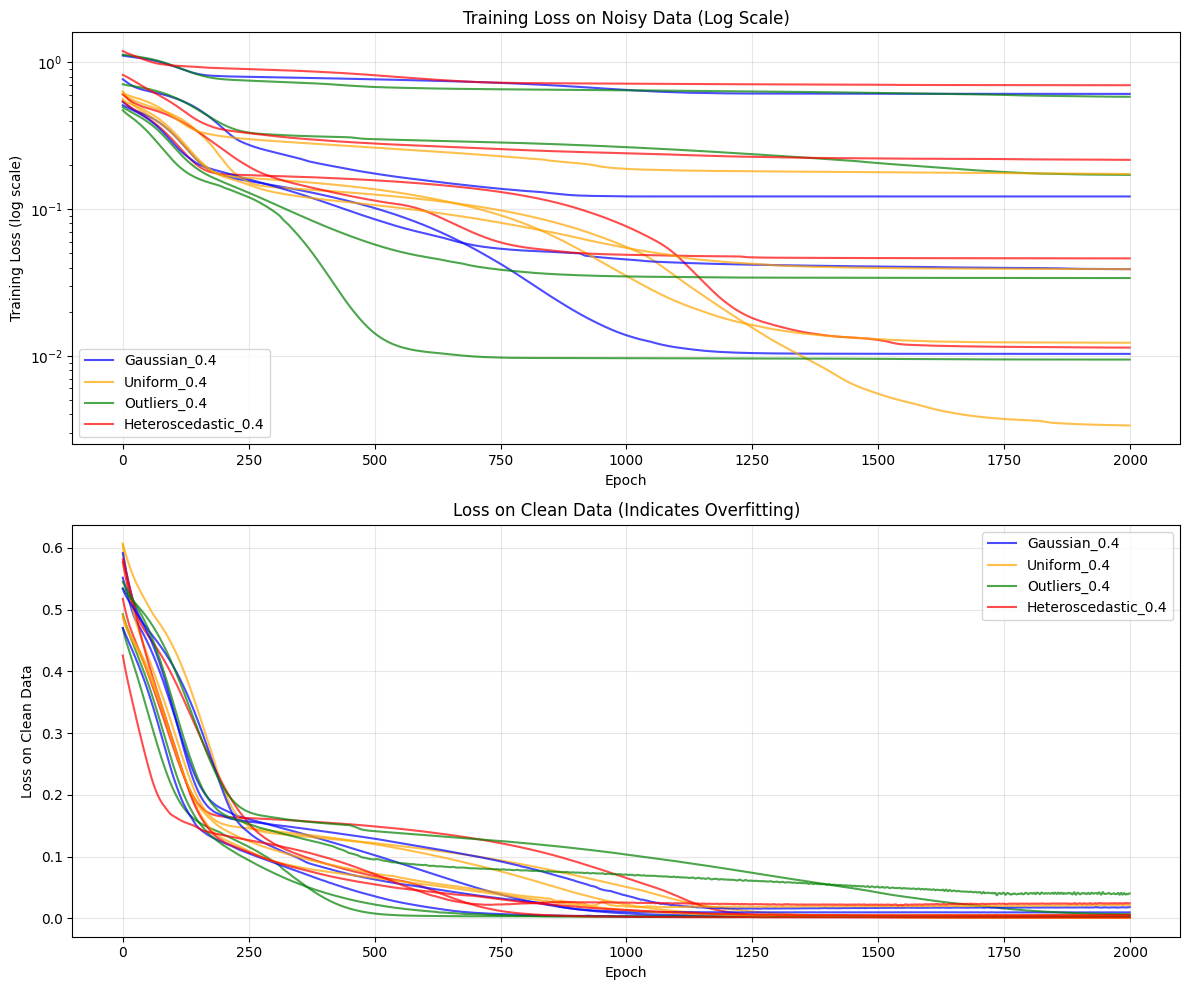


=== 噪声影响总结 ===
Noise Type           Intensity  Final Train Loss     Final Clean Loss     Overfit Score  
Gaussian             0.1        0.010313             0.004258             0.41           
Gaussian             0.2        0.038985             0.004579             0.12           
Gaussian             0.4        0.122019             0.009899             0.08           
Gaussian             0.8        0.610047             0.018516             0.03           
Heteroscedastic      0.1        0.011378             0.001957             0.17           
Heteroscedastic      0.2        0.046179             0.001933             0.04           
Heteroscedastic      0.4        0.216629             0.005784             0.03           
Heteroscedastic      0.8        0.699137             0.024554             0.04           
Outliers             0.1        0.009434             0.003532             0.37           
Outliers             0.2        0.033908             0.002836             0.08      

In [9]:
#%% 2. 不同噪声类型和强度的影响
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy import stats

np.random.seed(42)
torch.manual_seed(42)

# 生成基础数据
num_points = 100
x = np.linspace(0, 1, num_points)
y_true = np.sin(2 * np.pi * x)

# 定义不同噪声类型
def add_gaussian_noise(y, intensity=0.4):
    """高斯噪声"""
    noise = np.random.normal(0, intensity, len(y))
    return y + noise

def add_uniform_noise(y, intensity=0.4):
    """均匀分布噪声"""
    noise = np.random.uniform(-intensity, intensity, len(y))
    return y + noise

def add_outliers(y, intensity=0.4, outlier_prob=0.1):
    """加入离群点"""
    noisy_y = y.copy()
    num_outliers = int(len(y) * outlier_prob)
    outlier_indices = np.random.choice(len(y), num_outliers, replace=False)
    for idx in outlier_indices:
        noisy_y[idx] += np.random.choice([-1, 1]) * intensity * 3
    noise = np.random.normal(0, intensity * 0.3, len(y))
    return noisy_y + noise

def add_heteroscedastic_noise(y, base_intensity=0.2):
    """异方差噪声（噪声强度与位置相关）"""
    noise_intensity = base_intensity * (0.5 + np.abs(np.sin(4 * np.pi * x)))
    noise = np.random.normal(0, noise_intensity)
    return y + noise

# 创建带不同噪声的数据集
noise_intensities = [0.1, 0.2, 0.4, 0.8]
noise_types = ['Gaussian', 'Uniform', 'Outliers', 'Heteroscedastic']

datasets = {}
for intensity in noise_intensities:
    datasets[f'Gaussian_{intensity}'] = add_gaussian_noise(y_true, intensity)
    datasets[f'Uniform_{intensity}'] = add_uniform_noise(y_true, intensity)
    datasets[f'Outliers_{intensity}'] = add_outliers(y_true, intensity)
    datasets[f'Heteroscedastic_{intensity}'] = add_heteroscedastic_noise(y_true, intensity)

# 定义简单的MLP
class NoiseMLP(nn.Module):
    def __init__(self, hidden_units=16):
        super(NoiseMLP, self).__init__()
        self.hidden1 = nn.Linear(1, hidden_units)
        self.hidden2 = nn.Linear(hidden_units, hidden_units)
        self.output = nn.Linear(hidden_units, 1)
    
    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        x = self.output(x)
        return x

# 训练函数
def train_on_dataset(x_tensor, y_noisy_tensor, y_true_tensor, hidden_units=16, epochs=2000):
    model = NoiseMLP(hidden_units=hidden_units)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_losses = []
    clean_losses = []
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(x_tensor)
        loss = criterion(outputs, y_noisy_tensor)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        
        # 计算在干净数据上的损失
        model.eval()
        with torch.no_grad():
            clean_outputs = model(x_tensor)
            clean_loss = criterion(clean_outputs, y_true_tensor).item()
            clean_losses.append(clean_loss)
        model.train()
    
    return model, train_losses, clean_losses

# 转换为tensor
x_tensor = torch.tensor(x, dtype=torch.float32).view(-1, 1)
y_true_tensor = torch.tensor(y_true, dtype=torch.float32).view(-1, 1)

# 训练并记录结果
results = {}
for name, y_noisy in datasets.items():
    print(f"Training on {name}...")
    y_noisy_tensor = torch.tensor(y_noisy, dtype=torch.float32).view(-1, 1)
    model, train_losses, clean_losses = train_on_dataset(x_tensor, y_noisy_tensor, y_true_tensor)
    
    model.eval()
    with torch.no_grad():
        predicted = model(x_tensor).numpy()
    
    results[name] = {
        'y_noisy': y_noisy,
        'train_losses': train_losses,
        'clean_losses': clean_losses,
        'predicted': predicted,
        'final_train_loss': train_losses[-1],
        'final_clean_loss': clean_losses[-1]
    }

# 可视化结果
fig, axes = plt.subplots(4, 4, figsize=(20, 16))
axes = axes.flatten()

for idx, (name, result) in enumerate(results.items()):
    ax = axes[idx]
    noise_type = name.split('_')[0]
    intensity = name.split('_')[1]
    
    # 绘制拟合结果
    ax.scatter(x, result['y_noisy'], alpha=0.5, s=10, label='Noisy Data')
    ax.plot(x, y_true, 'g-', linewidth=2, label='True Function')
    ax.plot(x, result['predicted'], 'r--', linewidth=2, label='MLP Fit')
    
    ax.set_title(f'{noise_type} Noise (Intensity={intensity})')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('noise_comparison_fits.png', dpi=150, bbox_inches='tight')
plt.show()

# 绘制损失曲线对比
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# 按噪声类型分组
colors = {'Gaussian': 'blue', 'Uniform': 'orange', 'Outliers': 'green', 'Heteroscedastic': 'red'}

for name, result in results.items():
    noise_type = name.split('_')[0]
    intensity = name.split('_')[1]
    color = colors[noise_type]
    
    # 训练损失
    ax1.plot(result['train_losses'], color=color, alpha=0.7, 
             label=f'{noise_type}_{intensity}' if intensity == '0.4' else None)
    
    # 干净数据损失
    ax2.plot(result['clean_losses'], color=color, alpha=0.7,
             label=f'{noise_type}_{intensity}' if intensity == '0.4' else None)

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss (log scale)')
ax1.set_title('Training Loss on Noisy Data (Log Scale)')
ax1.set_yscale('log')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss on Clean Data')
ax2.set_title('Loss on Clean Data (Indicates Overfitting)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('noise_loss_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# 打印总结表格
print("\n=== 噪声影响总结 ===")
print(f"{'Noise Type':<20} {'Intensity':<10} {'Final Train Loss':<20} {'Final Clean Loss':<20} {'Overfit Score':<15}")
print("=" * 85)

for name in sorted(results.keys()):
    result = results[name]
    noise_type = name.split('_')[0]
    intensity = name.split('_')[1]
    overfit_score = result['final_clean_loss'] / result['final_train_loss'] if result['final_train_loss'] > 0 else float('inf')
    
    print(f"{noise_type:<20} {intensity:<10} {result['final_train_loss']:<20.6f} "
          f"{result['final_clean_loss']:<20.6f} {overfit_score:<15.2f}")

# 3. 模型外推能力分析


Training Small Network...
  Epoch [1000/3000], Loss: 0.1900
  Epoch [2000/3000], Loss: 0.1512
  Epoch [3000/3000], Loss: 0.1343

Training Medium Network...
  Epoch [1000/3000], Loss: 0.1175
  Epoch [2000/3000], Loss: 0.1162
  Epoch [3000/3000], Loss: 0.1148

Training Large Network...
  Epoch [1000/3000], Loss: 0.0964
  Epoch [2000/3000], Loss: 0.0809
  Epoch [3000/3000], Loss: 0.0760


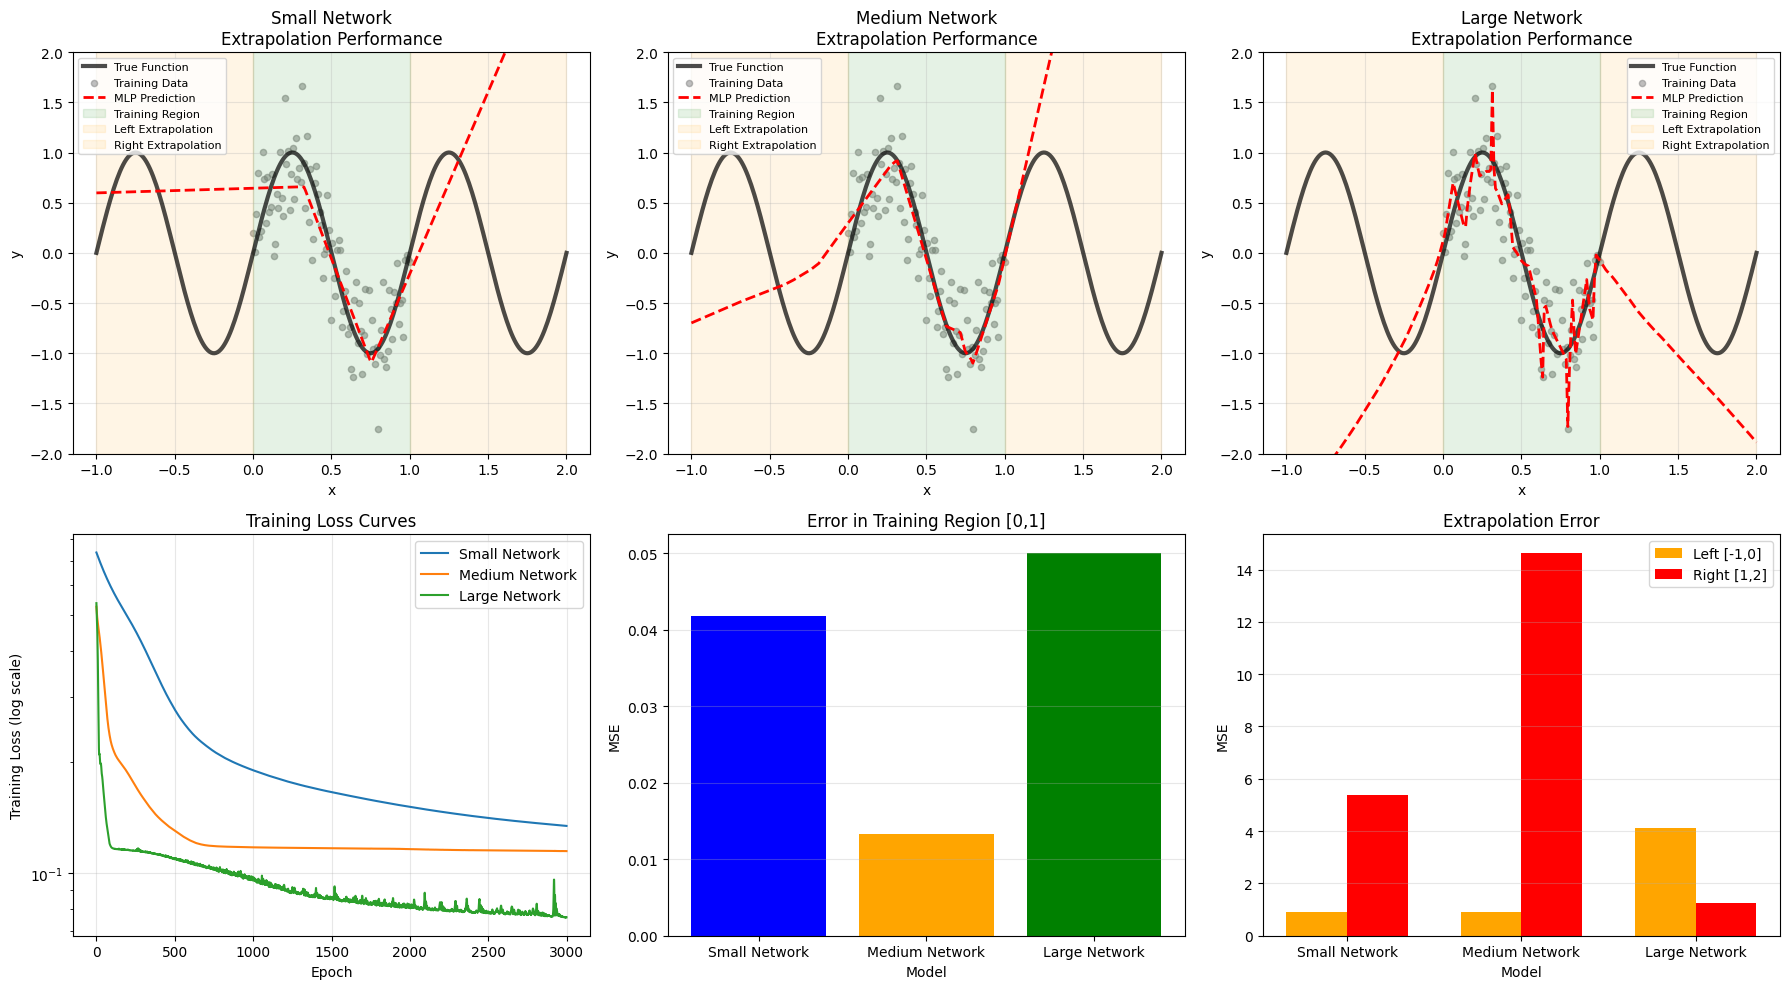


=== 外推能力详细分析 ===

Model                Train MSE       Left Extrap MSE      Right Extrap MSE     Extrap/ Train Ratio 
Small Network        0.041866        0.898506             5.366403             74.82               
Medium Network       0.013327        0.916655             14.617596            582.79              
Large Network        0.049999        4.128037             1.245217             53.73               


In [10]:
#%% 3. 模型外推能力分析
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

np.random.seed(42)
torch.manual_seed(42)

# 生成训练数据（只在[0,1]区间）
train_points = 100
x_train = np.linspace(0, 1, train_points)
y_true = np.sin(2 * np.pi * x_train)
noise = np.random.normal(0, 0.4, len(y_true))
y_train = y_true + noise

# 定义测试数据（包括外推区间）
x_test = np.linspace(-1, 2, 300)  # 包括训练区间和外推区间
y_test_true = np.sin(2 * np.pi * x_test)

# 转换为tensor
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).view(-1, 1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).view(-1, 1)

# 定义不同复杂度的MLP
class ExtrapolationMLP(nn.Module):
    def __init__(self, hidden_units=32, num_layers=3):
        super(ExtrapolationMLP, self).__init__()
        self.layers = nn.ModuleList()
        
        # 输入层
        self.layers.append(nn.Linear(1, hidden_units))
        
        # 隐藏层
        for _ in range(num_layers - 2):
            self.layers.append(nn.Linear(hidden_units, hidden_units))
        
        # 输出层
        self.layers.append(nn.Linear(hidden_units, 1))
    
    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            x = torch.relu(layer(x))
        x = self.layers[-1](x)
        return x

# 训练不同复杂度的模型
configs = [
    {'hidden_units': 8, 'num_layers': 2, 'name': 'Small Network'},
    {'hidden_units': 32, 'num_layers': 3, 'name': 'Medium Network'},
    {'hidden_units': 128, 'num_layers': 5, 'name': 'Large Network'}
]

models = {}
predictions = {}
train_losses = {}

for config in configs:
    print(f"\nTraining {config['name']}...")
    
    model = ExtrapolationMLP(hidden_units=config['hidden_units'], 
                            num_layers=config['num_layers'])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # 训练
    losses = []
    num_epochs = 3000
    
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(x_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        if (epoch+1) % 1000 == 0:
            print(f'  Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    # 评估
    model.eval()
    with torch.no_grad():
        # 在训练区间和外推区间都进行预测
        train_pred = model(x_train_tensor).numpy().flatten()
        test_pred = model(x_test_tensor).numpy().flatten()
    
    models[config['name']] = model
    predictions[config['name']] = {
        'train': train_pred,
        'test': test_pred
    }
    train_losses[config['name']] = losses

# 可视化外推结果
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 第一行：不同模型的外推能力
for idx, (name, preds) in enumerate(predictions.items()):
    ax = axes[0, idx]
    
    # 绘制真实函数
    ax.plot(x_test, y_test_true, 'k-', linewidth=3, label='True Function', alpha=0.7)
    
    # 绘制训练数据
    ax.scatter(x_train, y_train, alpha=0.5, s=20, label='Training Data', color='gray')
    
    # 绘制预测结果
    ax.plot(x_test, preds['test'], 'r--', linewidth=2, label='MLP Prediction')
    
    # 标记训练区间
    ax.axvspan(0, 1, alpha=0.1, color='green', label='Training Region')
    ax.axvspan(-1, 0, alpha=0.1, color='orange', label='Left Extrapolation')
    ax.axvspan(1, 2, alpha=0.1, color='orange', label='Right Extrapolation')
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f'{name}\nExtrapolation Performance')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([-2, 2])

# 第二行：损失曲线和误差分析
# 损失曲线
ax1 = axes[1, 0]
for name, losses in train_losses.items():
    ax1.plot(losses, label=name)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss (log scale)')
ax1.set_title('Training Loss Curves')
ax1.set_yscale('log')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 训练区间误差
ax2 = axes[1, 1]
train_errors = []
names = []
for name, preds in predictions.items():
    train_mask = (x_test >= 0) & (x_test <= 1)
    train_error = np.mean((preds['test'][train_mask] - y_test_true[train_mask])**2)
    train_errors.append(train_error)
    names.append(name)

bars = ax2.bar(names, train_errors, color=['blue', 'orange', 'green'])
ax2.set_xlabel('Model')
ax2.set_ylabel('MSE')
ax2.set_title('Error in Training Region [0,1]')
ax2.grid(True, alpha=0.3, axis='y')

# 外推区间误差
ax3 = axes[1, 2]
extrapolation_errors = []
for name, preds in predictions.items():
    # 左外推误差
    left_mask = (x_test >= -1) & (x_test < 0)
    left_error = np.mean((preds['test'][left_mask] - y_test_true[left_mask])**2)
    
    # 右外推误差
    right_mask = (x_test > 1) & (x_test <= 2)
    right_error = np.mean((preds['test'][right_mask] - y_test_true[right_mask])**2)
    
    extrapolation_errors.append((left_error, right_error))

x_pos = np.arange(len(names))
width = 0.35
ax3.bar(x_pos - width/2, [e[0] for e in extrapolation_errors], width, label='Left [-1,0]', color='orange')
ax3.bar(x_pos + width/2, [e[1] for e in extrapolation_errors], width, label='Right [1,2]', color='red')
ax3.set_xlabel('Model')
ax3.set_ylabel('MSE')
ax3.set_title('Extrapolation Error')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(names)
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('extrapolation_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# 计算并打印详细的误差分析
print("\n=== 外推能力详细分析 ===")
print(f"\n{'Model':<20} {'Train MSE':<15} {'Left Extrap MSE':<20} {'Right Extrap MSE':<20} {'Extrap/ Train Ratio':<20}")
print("=" * 95)

for name, preds in predictions.items():
    # 训练区间误差
    train_mask = (x_test >= 0) & (x_test <= 1)
    train_mse = np.mean((preds['test'][train_mask] - y_test_true[train_mask])**2)
    
    # 左外推误差
    left_mask = (x_test >= -1) & (x_test < 0)
    left_mse = np.mean((preds['test'][left_mask] - y_test_true[left_mask])**2)
    
    # 右外推误差
    right_mask = (x_test > 1) & (x_test <= 2)
    right_mse = np.mean((preds['test'][right_mask] - y_test_true[right_mask])**2)
    
    extrap_ratio = (left_mse + right_mse) / (2 * train_mse) if train_mse > 0 else float('inf')
    
    print(f"{name:<20} {train_mse:<15.6f} {left_mse:<20.6f} {right_mse:<20.6f} {extrap_ratio:<20.2f}")


# 4. 超参数影响分析


Training models with different hyperparameters...

Training model 1/8:
  Hidden units: 8, Layers: 2, Activation: relu, LR: 0.001, Dropout: 0.0

Training model 2/8:
  Hidden units: 32, Layers: 3, Activation: relu, LR: 0.001, Dropout: 0.0

Training model 3/8:
  Hidden units: 128, Layers: 5, Activation: relu, LR: 0.001, Dropout: 0.0

Training model 4/8:
  Hidden units: 32, Layers: 3, Activation: tanh, LR: 0.001, Dropout: 0.0

Training model 5/8:
  Hidden units: 32, Layers: 3, Activation: sigmoid, LR: 0.001, Dropout: 0.0

Training model 6/8:
  Hidden units: 32, Layers: 3, Activation: relu, LR: 0.01, Dropout: 0.0

Training model 7/8:
  Hidden units: 32, Layers: 3, Activation: relu, LR: 0.001, Dropout: 0.2

Training model 8/8:
  Hidden units: 32, Layers: 3, Activation: relu, LR: 0.001, Dropout: 0.5


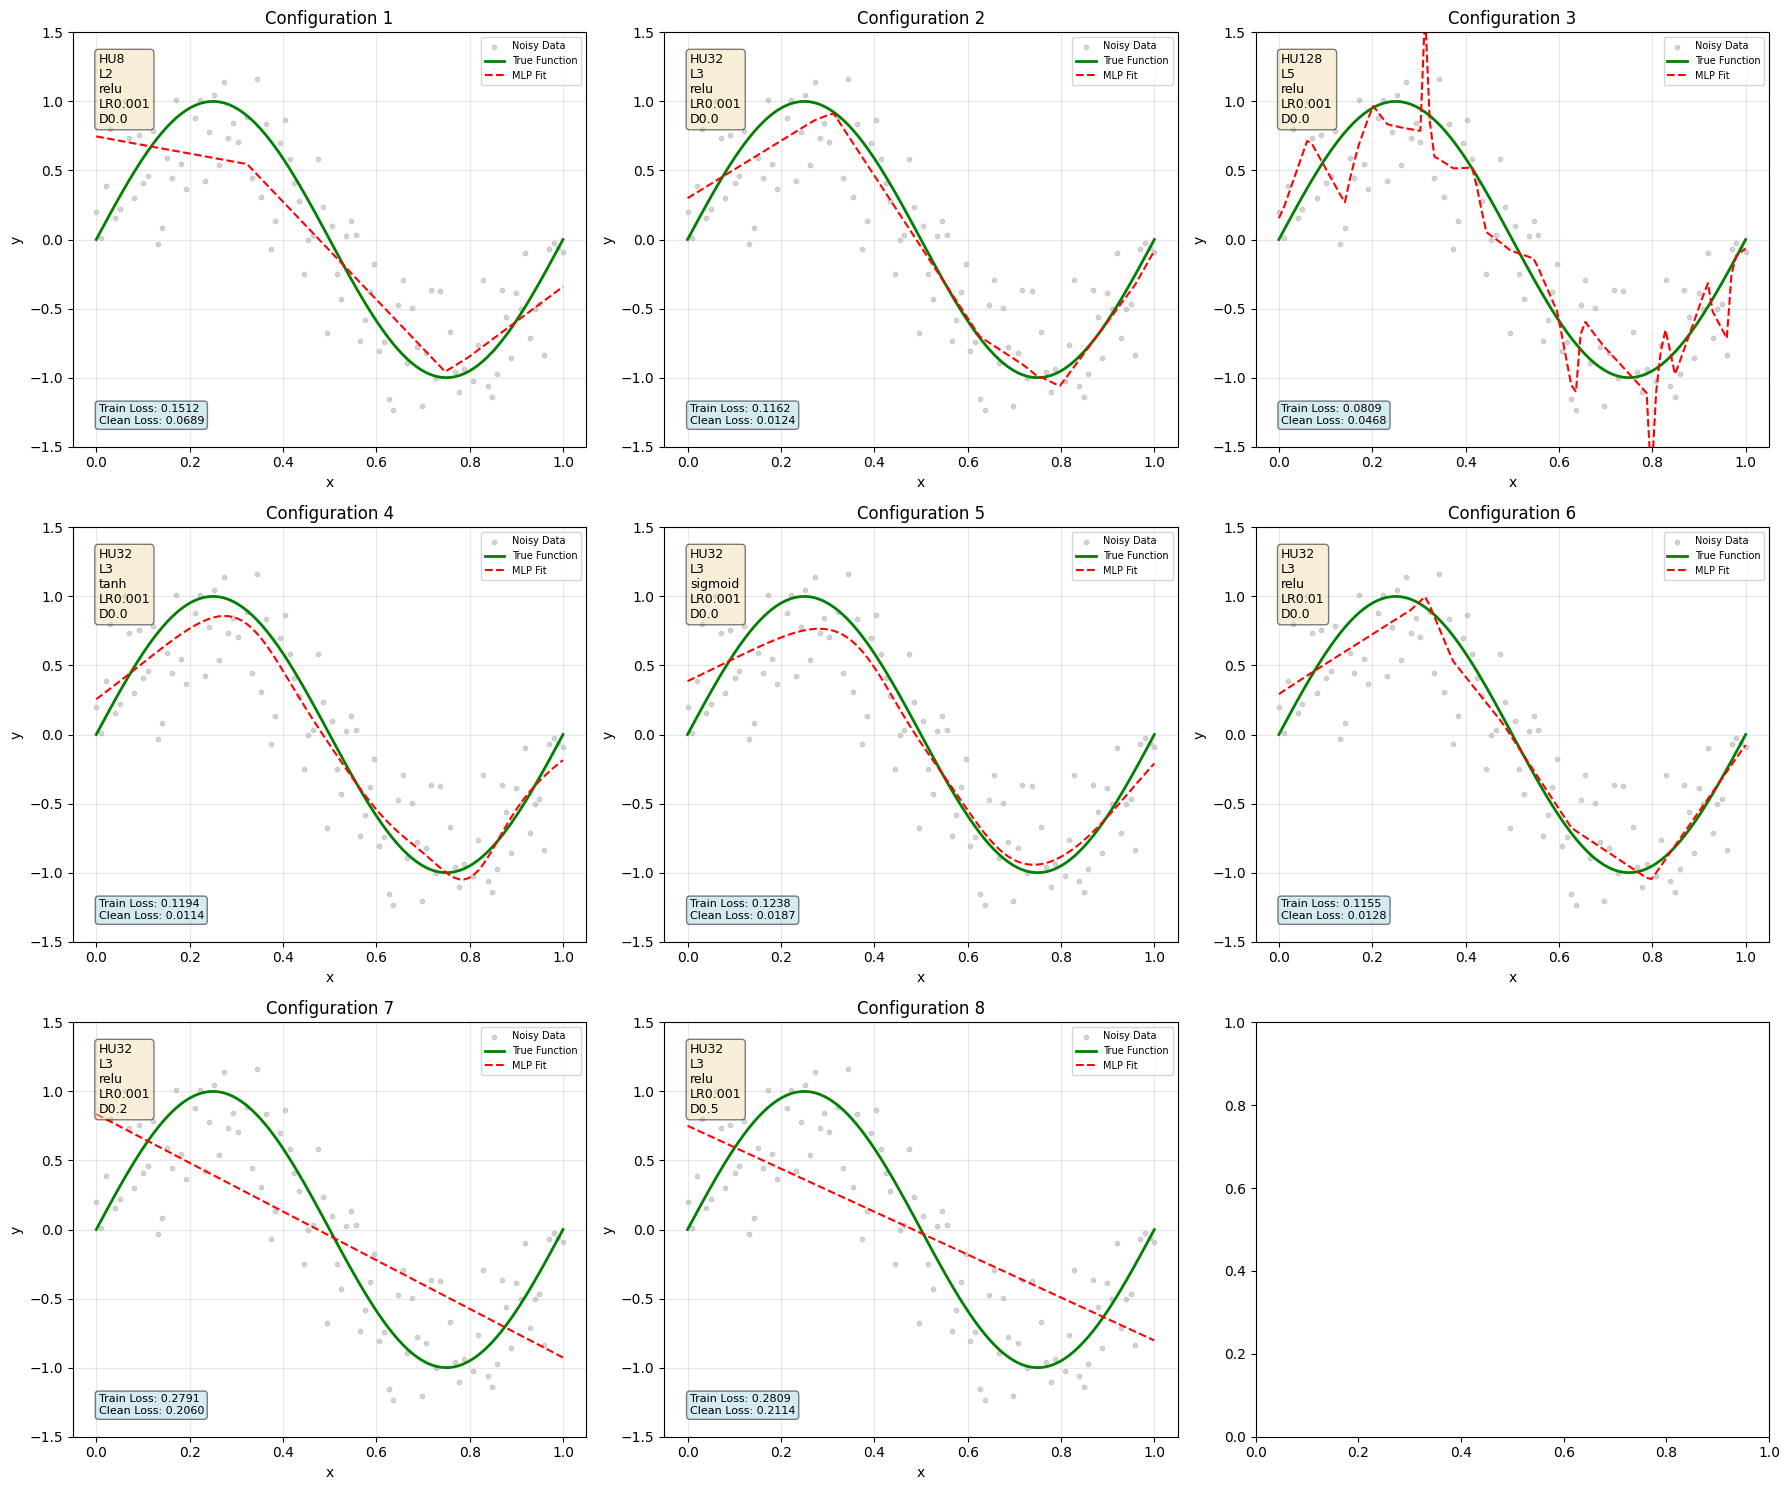

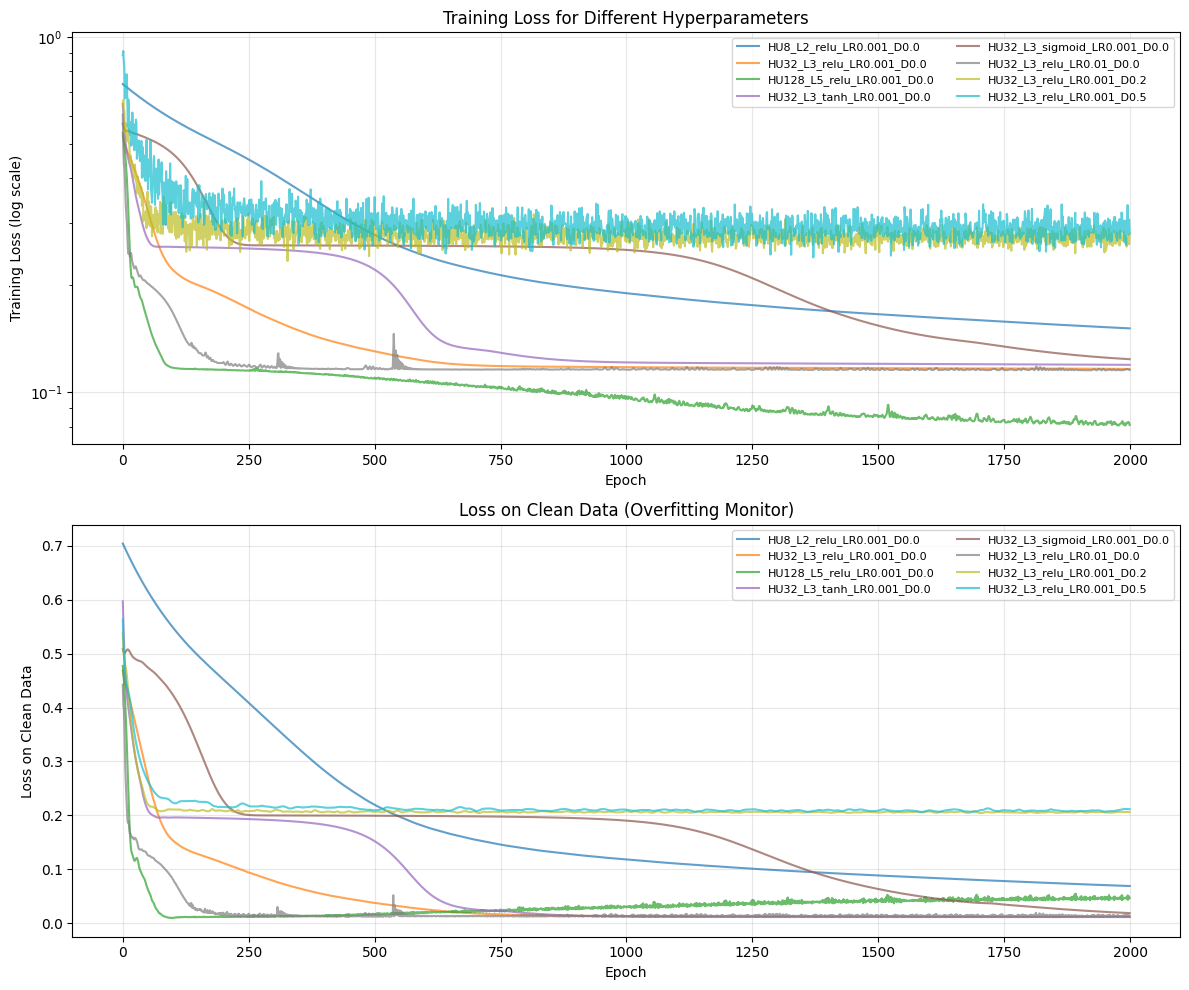

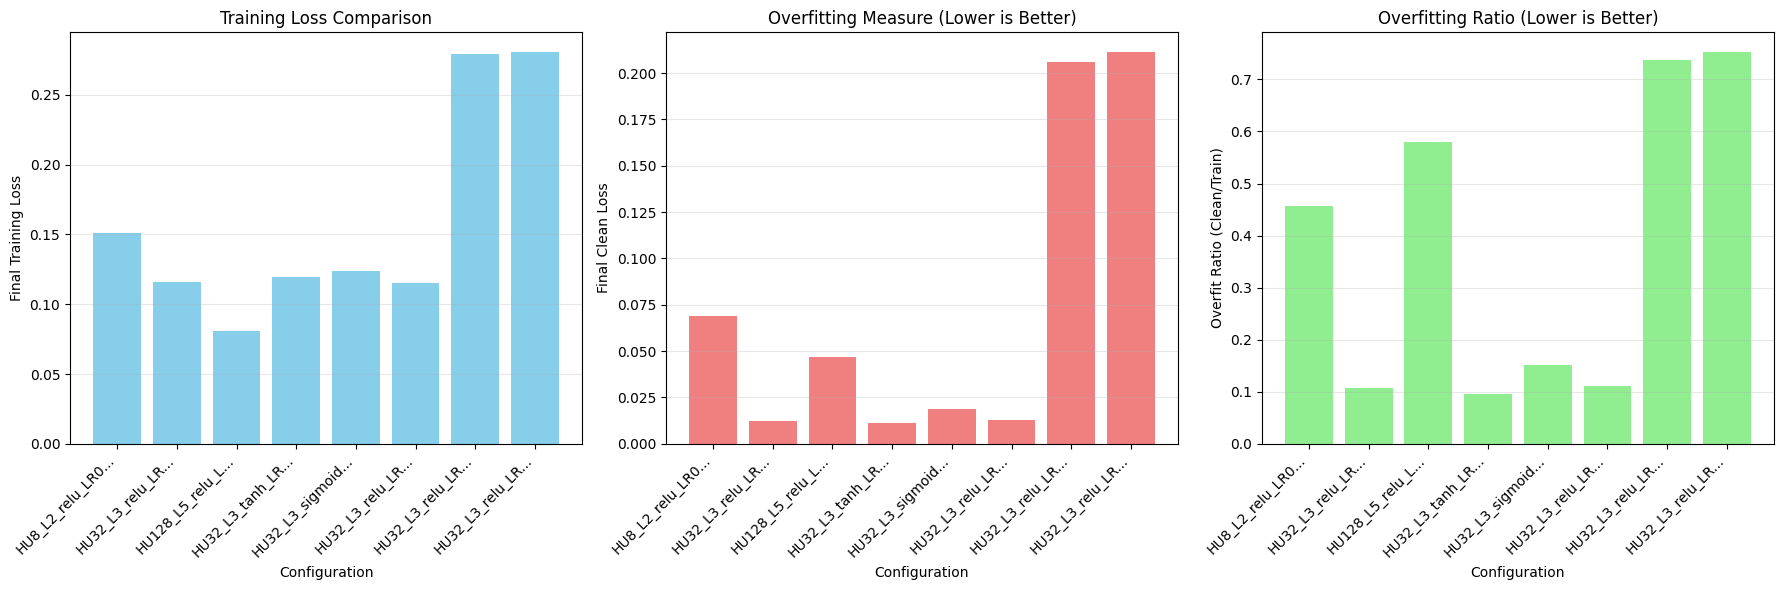


超参数影响分析总结

Configuration                            Train Loss      Clean Loss      Overfit Ratio   Interpretation                
------------------------------------------------------------------------------------------------------------------------
HU8_L2_relu_LR0.001_D0.0                 0.151195        0.068928        0.46            拟合良好                          
HU32_L3_relu_LR0.001_D0.0                0.116221        0.012430        0.11            拟合良好                          
HU128_L5_relu_LR0.001_D0.0               0.080855        0.046823        0.58            拟合良好, 模型复杂                    
HU32_L3_tanh_LR0.001_D0.0                0.119387        0.011357        0.10            拟合良好                          
HU32_L3_sigmoid_LR0.001_D0.0             0.123825        0.018695        0.15            拟合良好                          
HU32_L3_relu_LR0.01_D0.0                 0.115504        0.012755        0.11            拟合良好                          
HU32_L3_relu_LR0.001_D0.2  

In [11]:
#%% 4. 超参数影响分析
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from itertools import product

np.random.seed(42)
torch.manual_seed(42)

# 生成数据
num_points = 100
x = np.linspace(0, 1, num_points)
y_true = np.sin(2 * np.pi * x)
noise = np.random.normal(0, 0.4, len(y_true))
y_noisy = y_true + noise

# 转换为tensor
x_tensor = torch.tensor(x, dtype=torch.float32).view(-1, 1)
y_tensor = torch.tensor(y_noisy, dtype=torch.float32).view(-1, 1)
y_true_tensor = torch.tensor(y_true, dtype=torch.float32).view(-1, 1)

# 灵活的MLP定义
class FlexibleMLP(nn.Module):
    def __init__(self, input_dim=1, hidden_units=32, num_layers=3, 
                 activation='relu', dropout_rate=0.0):
        super(FlexibleMLP, self).__init__()
        
        self.layers = nn.ModuleList()
        self.activation_name = activation
        
        # 定义激活函数
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'leaky_relu':
            self.activation = nn.LeakyReLU(0.1)
        elif activation == 'elu':
            self.activation = nn.ELU()
        else:
            self.activation = nn.ReLU()
        
        # 输入层
        self.layers.append(nn.Linear(input_dim, hidden_units))
        if dropout_rate > 0:
            self.layers.append(nn.Dropout(dropout_rate))
        
        # 隐藏层
        for _ in range(num_layers - 2):
            self.layers.append(nn.Linear(hidden_units, hidden_units))
            if dropout_rate > 0:
                self.layers.append(nn.Dropout(dropout_rate))
        
        # 输出层
        self.layers.append(nn.Linear(hidden_units, 1))
    
    def forward(self, x):
        for i, layer in enumerate(self.layers):
            if isinstance(layer, nn.Linear):
                x = layer(x)
                # 只在隐藏层应用激活函数，不在输出层
                if i < len(self.layers) - 1 and not isinstance(self.layers[i+1], nn.Dropout):
                    x = self.activation(x)
            elif isinstance(layer, nn.Dropout):
                if self.training:  # 只在训练时使用dropout
                    x = layer(x)
        return x

# 超参数网格搜索
hyperparam_grid = {
    'hidden_units': [8, 16, 32, 64, 128],
    'num_layers': [2, 3, 4, 5],
    'activation': ['relu', 'tanh', 'sigmoid', 'leaky_relu'],
    'learning_rate': [0.001, 0.01, 0.1],
    'dropout_rate': [0.0, 0.2, 0.5]
}

# 选择一部分组合进行测试（为了节省时间）
selected_combinations = [
    {'hidden_units': 8, 'num_layers': 2, 'activation': 'relu', 'learning_rate': 0.001, 'dropout_rate': 0.0},
    {'hidden_units': 32, 'num_layers': 3, 'activation': 'relu', 'learning_rate': 0.001, 'dropout_rate': 0.0},
    {'hidden_units': 128, 'num_layers': 5, 'activation': 'relu', 'learning_rate': 0.001, 'dropout_rate': 0.0},
    {'hidden_units': 32, 'num_layers': 3, 'activation': 'tanh', 'learning_rate': 0.001, 'dropout_rate': 0.0},
    {'hidden_units': 32, 'num_layers': 3, 'activation': 'sigmoid', 'learning_rate': 0.001, 'dropout_rate': 0.0},
    {'hidden_units': 32, 'num_layers': 3, 'activation': 'relu', 'learning_rate': 0.01, 'dropout_rate': 0.0},
    {'hidden_units': 32, 'num_layers': 3, 'activation': 'relu', 'learning_rate': 0.001, 'dropout_rate': 0.2},
    {'hidden_units': 32, 'num_layers': 3, 'activation': 'relu', 'learning_rate': 0.001, 'dropout_rate': 0.5},
]

# 训练函数
def train_model(params, epochs=2000):
    model = FlexibleMLP(
        hidden_units=params['hidden_units'],
        num_layers=params['num_layers'],
        activation=params['activation'],
        dropout_rate=params['dropout_rate']
    )
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    
    train_losses = []
    clean_losses = []
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(x_tensor)
        loss = criterion(outputs, y_tensor)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        
        # 在干净数据上评估
        model.eval()
        with torch.no_grad():
            clean_outputs = model(x_tensor)
            clean_loss = criterion(clean_outputs, y_true_tensor).item()
            clean_losses.append(clean_loss)
        
        model.train()
    
    # 最终评估
    model.eval()
    with torch.no_grad():
        predicted = model(x_tensor).numpy().flatten()
    
    return {
        'model': model,
        'train_losses': train_losses,
        'clean_losses': clean_losses,
        'predicted': predicted,
        'final_train_loss': train_losses[-1],
        'final_clean_loss': clean_losses[-1],
        'overfit_ratio': clean_losses[-1] / train_losses[-1] if train_losses[-1] > 0 else float('inf')
    }

# 训练所有配置
results = {}
print("Training models with different hyperparameters...")
for i, params in enumerate(selected_combinations):
    print(f"\nTraining model {i+1}/{len(selected_combinations)}:")
    print(f"  Hidden units: {params['hidden_units']}, Layers: {params['num_layers']}, "
          f"Activation: {params['activation']}, LR: {params['learning_rate']}, "
          f"Dropout: {params['dropout_rate']}")
    
    key = f"HU{params['hidden_units']}_L{params['num_layers']}_{params['activation']}_LR{params['learning_rate']}_D{params['dropout_rate']}"
    results[key] = train_model(params)

# 可视化结果
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

for idx, (key, result) in enumerate(list(results.items())[:9]):
    ax = axes[idx]
    
    # 绘制拟合结果
    ax.scatter(x, y_noisy, alpha=0.3, s=10, color='gray', label='Noisy Data')
    ax.plot(x, y_true, 'g-', linewidth=2, label='True Function')
    ax.plot(x, result['predicted'], 'r--', linewidth=1.5, label='MLP Fit')
    
    # 添加配置信息
    config_info = key.replace('_', '\n')
    ax.text(0.05, 0.95, config_info, transform=ax.transAxes, 
            fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # 添加性能指标
    perf_text = f"Train Loss: {result['final_train_loss']:.4f}\nClean Loss: {result['final_clean_loss']:.4f}"
    ax.text(0.05, 0.05, perf_text, transform=ax.transAxes,
            fontsize=8, verticalalignment='bottom',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f'Configuration {idx+1}')
    ax.legend(fontsize=7, loc='upper right')
    ax.grid(True, alpha=0.3)
    ax.set_ylim([-1.5, 1.5])

plt.tight_layout()
plt.savefig('hyperparameter_fits.png', dpi=150, bbox_inches='tight')
plt.show()

# 损失曲线对比
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# 按类别分组
colors = plt.cm.tab10(np.linspace(0, 1, len(results)))

for (key, result), color in zip(results.items(), colors):
    # 训练损失
    ax1.plot(result['train_losses'], color=color, alpha=0.7, label=key)
    
    # 干净数据损失（过拟合指标）
    ax2.plot(result['clean_losses'], color=color, alpha=0.7, label=key)

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss (log scale)')
ax1.set_title('Training Loss for Different Hyperparameters')
ax1.set_yscale('log')
ax1.legend(fontsize=8, ncol=2)
ax1.grid(True, alpha=0.3)

ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss on Clean Data')
ax2.set_title('Loss on Clean Data (Overfitting Monitor)')
ax2.legend(fontsize=8, ncol=2)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('hyperparameter_losses.png', dpi=150, bbox_inches='tight')
plt.show()

# 性能对比柱状图
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# 准备数据
keys = list(results.keys())
train_losses = [results[k]['final_train_loss'] for k in keys]
clean_losses = [results[k]['final_clean_loss'] for k in keys]
overfit_ratios = [results[k]['overfit_ratio'] for k in keys]

x_pos = np.arange(len(keys))

# 训练损失
bars1 = ax1.bar(x_pos, train_losses, color='skyblue')
ax1.set_xlabel('Configuration')
ax1.set_ylabel('Final Training Loss')
ax1.set_title('Training Loss Comparison')
ax1.set_xticks(x_pos)
ax1.set_xticklabels([k[:15] + '...' if len(k) > 15 else k for k in keys], rotation=45, ha='right')
ax1.grid(True, alpha=0.3, axis='y')

# 干净数据损失
bars2 = ax2.bar(x_pos, clean_losses, color='lightcoral')
ax2.set_xlabel('Configuration')
ax2.set_ylabel('Final Clean Loss')
ax2.set_title('Overfitting Measure (Lower is Better)')
ax2.set_xticks(x_pos)
ax2.set_xticklabels([k[:15] + '...' if len(k) > 15 else k for k in keys], rotation=45, ha='right')
ax2.grid(True, alpha=0.3, axis='y')

# 过拟合比率
bars3 = ax3.bar(x_pos, overfit_ratios, color='lightgreen')
ax3.set_xlabel('Configuration')
ax3.set_ylabel('Overfit Ratio (Clean/Train)')
ax3.set_title('Overfitting Ratio (Lower is Better)')
ax3.set_xticks(x_pos)
ax3.set_xticklabels([k[:15] + '...' if len(k) > 15 else k for k in keys], rotation=45, ha='right')
ax3.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('hyperparameter_performance.png', dpi=150, bbox_inches='tight')
plt.show()

# 打印详细分析
print("\n" + "="*100)
print("超参数影响分析总结")
print("="*100)

print(f"\n{'Configuration':<40} {'Train Loss':<15} {'Clean Loss':<15} {'Overfit Ratio':<15} {'Interpretation':<30}")
print("-"*120)

for key, result in results.items():
    # 提取配置信息
    hu = int(key.split('_')[0][2:]) if 'HU' in key.split('_')[0] else 32
    layers = int(key.split('_')[1][1:]) if 'L' in key.split('_')[1] else 3
    activation = key.split('_')[2] if len(key.split('_')) > 2 else 'relu'
    
    # 解释
    interpretation = []
    if result['overfit_ratio'] > 2.0:
        interpretation.append("严重过拟合")
    elif result['overfit_ratio'] > 1.5:
        interpretation.append("轻微过拟合")
    else:
        interpretation.append("拟合良好")
    
    if hu > 64:
        interpretation.append("模型复杂")
    if 'dropout' in key.lower():
        interpretation.append("正则化")
    
    interpret_str = ", ".join(interpretation)
    
    print(f"{key:<40} {result['final_train_loss']:<15.6f} {result['final_clean_loss']:<15.6f} "
          f"{result['overfit_ratio']:<15.2f} {interpret_str:<30}")

# 5. 其他有趣的问题：泛化能力与样本密度的关系


Training with 10 samples...
  Epoch [1000/3000], Train Loss: 0.0030, Test Loss: 0.0911
  Epoch [2000/3000], Train Loss: 0.0000, Test Loss: 0.1031
  Epoch [3000/3000], Train Loss: 0.0000, Test Loss: 0.1039

Training with 20 samples...
  Epoch [1000/3000], Train Loss: 0.0756, Test Loss: 0.0657
  Epoch [2000/3000], Train Loss: 0.0588, Test Loss: 0.0705
  Epoch [3000/3000], Train Loss: 0.0570, Test Loss: 0.0745

Training with 50 samples...
  Epoch [1000/3000], Train Loss: 0.1268, Test Loss: 0.0182
  Epoch [2000/3000], Train Loss: 0.1089, Test Loss: 0.0399
  Epoch [3000/3000], Train Loss: 0.1002, Test Loss: 0.0475

Training with 100 samples...
  Epoch [1000/3000], Train Loss: 0.1304, Test Loss: 0.0113
  Epoch [2000/3000], Train Loss: 0.1267, Test Loss: 0.0094
  Epoch [3000/3000], Train Loss: 0.1229, Test Loss: 0.0108

Training with 200 samples...
  Epoch [1000/3000], Train Loss: 0.1323, Test Loss: 0.0095
  Epoch [2000/3000], Train Loss: 0.1307, Test Loss: 0.0112
  Epoch [3000/3000], Train 

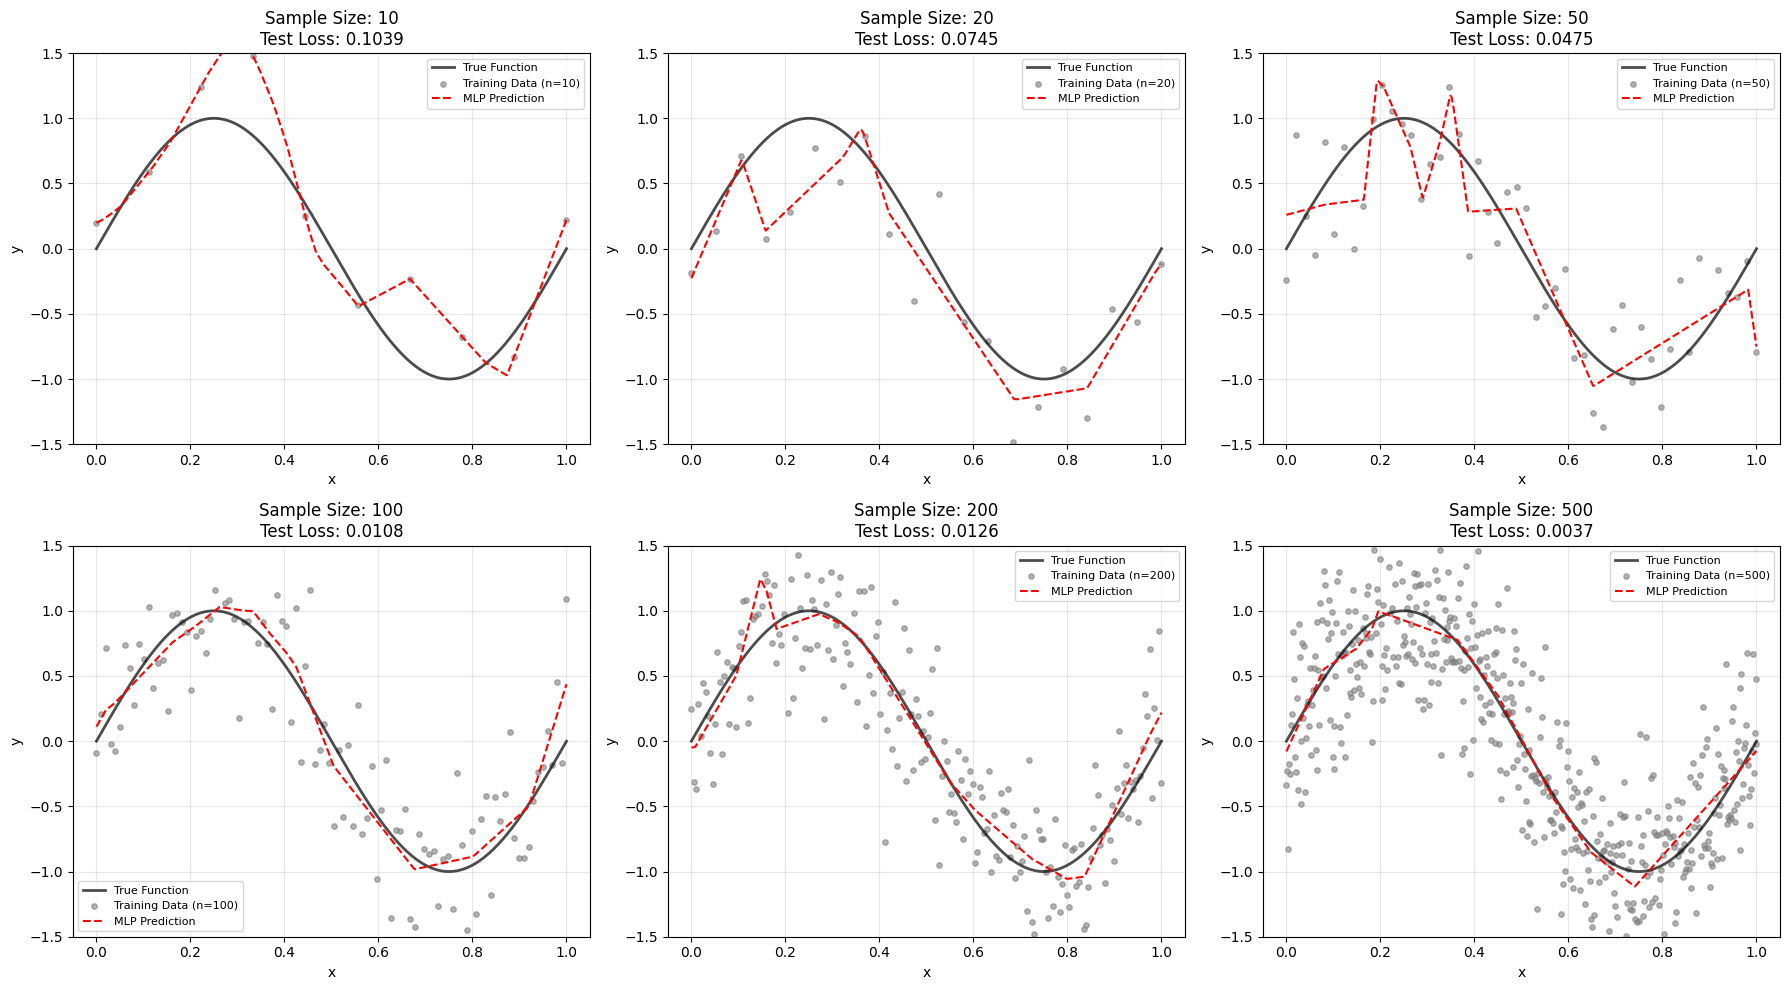

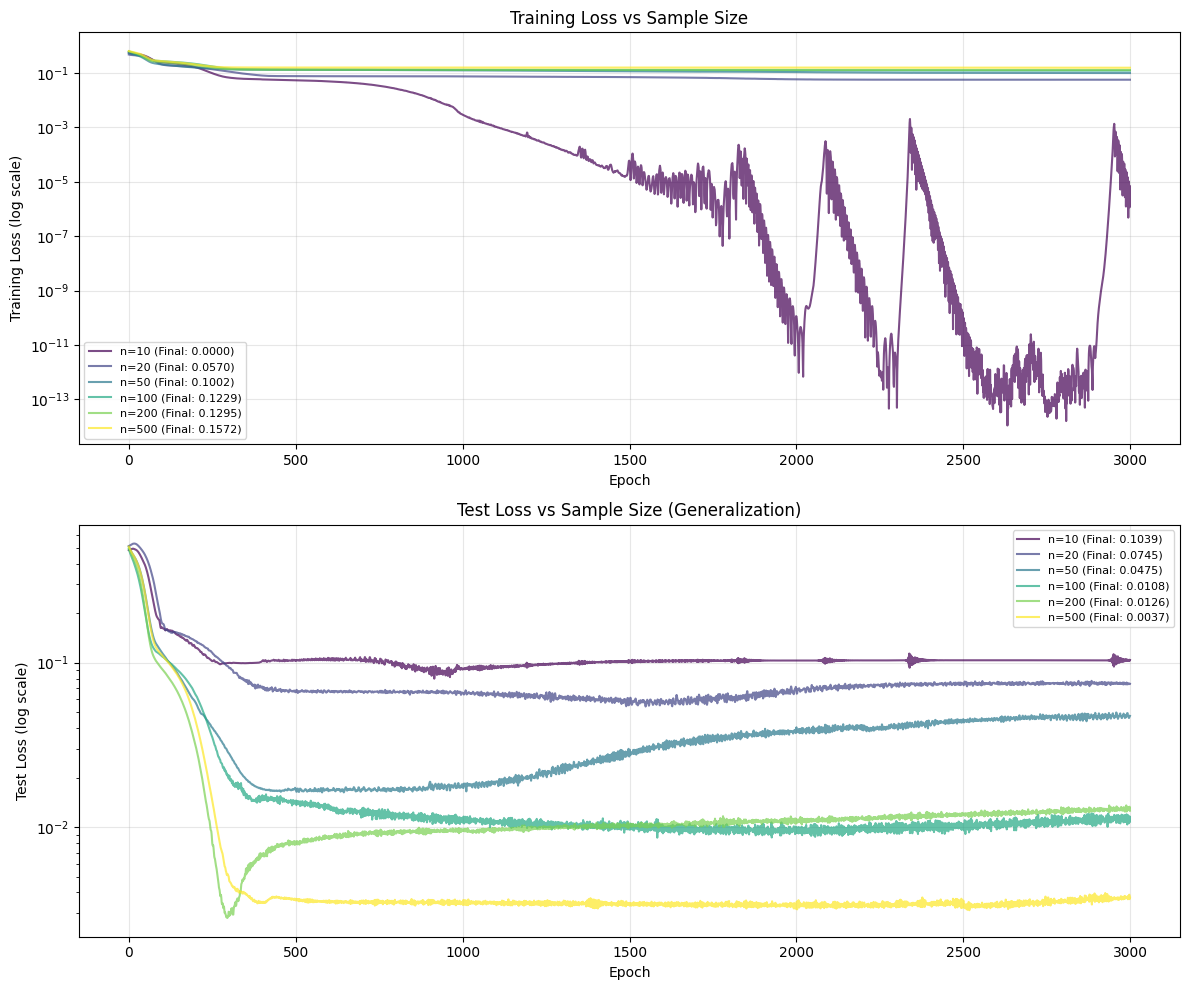


幂律拟合结果：测试损失 ~ n^-0.865 (R² = 0.937)


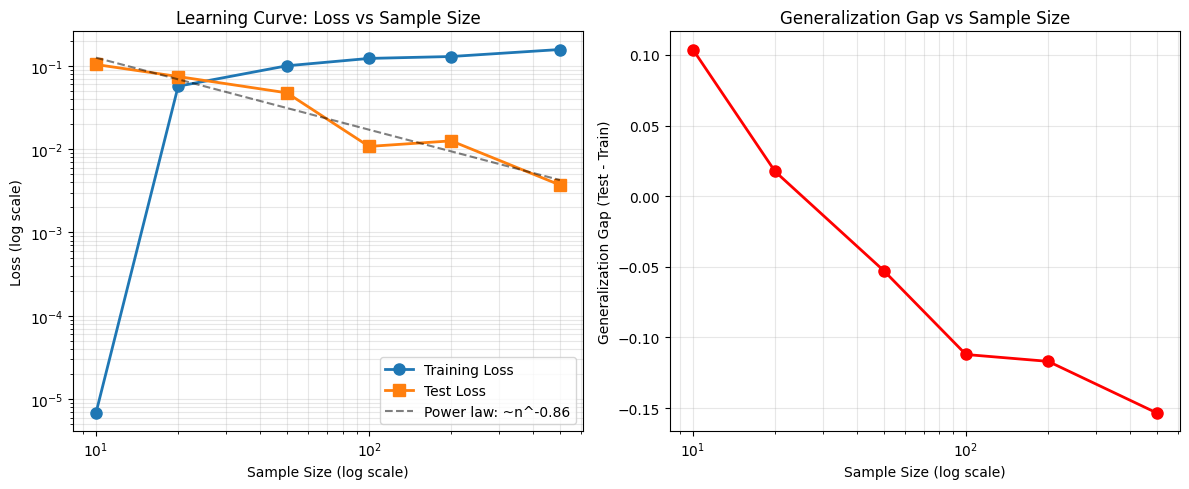


样本密度与泛化能力分析总结

Sample Size     Train Loss      Test Loss       Generalization Gap   Interpretation                
-----------------------------------------------------------------------------------------------
10              0.000007        0.103889        0.103882             轻微过拟合, 样本不足                   
20              0.056969        0.074461        0.017492             轻微过拟合                         
50              0.100201        0.047462        -0.052739            可能欠拟合                         
100             0.122893        0.010789        -0.112104            可能欠拟合                         
200             0.129545        0.012578        -0.116967            可能欠拟合                         
500             0.157216        0.003718        -0.153498            可能欠拟合, 样本充足                   


In [12]:
#%% 5. 泛化能力与样本密度的关系
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

np.random.seed(42)
torch.manual_seed(42)

# 测试不同的采样密度
sample_sizes = [10, 20, 50, 100, 200, 500]

# 高质量测试集（用于评估泛化能力）
x_test_dense = np.linspace(0, 1, 1000)
y_test_true = np.sin(2 * np.pi * x_test_dense)

results_by_samplesize = {}

for n_samples in sample_sizes:
    print(f"\nTraining with {n_samples} samples...")
    
    # 生成训练数据
    x_train = np.linspace(0, 1, n_samples)
    y_true = np.sin(2 * np.pi * x_train)
    noise = np.random.normal(0, 0.4, len(y_true))
    y_train = y_true + noise
    
    # 转换为tensor
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32).view(-1, 1)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    x_test_tensor = torch.tensor(x_test_dense, dtype=torch.float32).view(-1, 1)
    
    # 定义模型（固定结构）
    class FixedMLP(nn.Module):
        def __init__(self):
            super(FixedMLP, self).__init__()
            self.hidden1 = nn.Linear(1, 32)
            self.hidden2 = nn.Linear(32, 32)
            self.hidden3 = nn.Linear(32, 32)
            self.output = nn.Linear(32, 1)
            
        def forward(self, x):
            x = torch.relu(self.hidden1(x))
            x = torch.relu(self.hidden2(x))
            x = torch.relu(self.hidden3(x))
            x = self.output(x)
            return x
    
    # 训练
    model = FixedMLP()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_losses = []
    test_losses = []
    
    num_epochs = 3000
    
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(x_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        
        # 在测试集上评估
        model.eval()
        with torch.no_grad():
            test_outputs = model(x_test_tensor)
            test_loss = criterion(test_outputs, 
                                 torch.tensor(y_test_true, dtype=torch.float32).view(-1, 1)).item()
            test_losses.append(test_loss)
        model.train()
        
        if (epoch+1) % 1000 == 0:
            print(f'  Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss:.4f}')
    
    # 最终预测
    model.eval()
    with torch.no_grad():
        train_pred = model(x_train_tensor).numpy().flatten()
        test_pred = model(x_test_tensor).numpy().flatten()
    
    results_by_samplesize[n_samples] = {
        'x_train': x_train,
        'y_train': y_train,
        'train_pred': train_pred,
        'test_pred': test_pred,
        'train_losses': train_losses,
        'test_losses': test_losses,
        'final_train_loss': train_losses[-1],
        'final_test_loss': test_losses[-1],
        'generalization_gap': test_losses[-1] - train_losses[-1]
    }

# 可视化结果
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, (n_samples, result) in enumerate(results_by_samplesize.items()):
    ax = axes[idx]
    
    # 绘制真实函数
    ax.plot(x_test_dense, y_test_true, 'k-', linewidth=2, label='True Function', alpha=0.7)
    
    # 绘制训练数据
    ax.scatter(result['x_train'], result['y_train'], alpha=0.6, s=15, 
               label=f'Training Data (n={n_samples})', color='gray')
    
    # 绘制预测结果
    ax.plot(x_test_dense, result['test_pred'], 'r--', linewidth=1.5, label='MLP Prediction')
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f'Sample Size: {n_samples}\nTest Loss: {result["final_test_loss"]:.4f}')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([-1.5, 1.5])

plt.tight_layout()
plt.savefig('sample_size_effect.png', dpi=150, bbox_inches='tight')
plt.show()

# 损失曲线对比
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

colors = plt.cm.viridis(np.linspace(0, 1, len(sample_sizes)))

for (n_samples, result), color in zip(results_by_samplesize.items(), colors):
    # 训练损失
    ax1.plot(result['train_losses'], color=color, alpha=0.7, 
             label=f'n={n_samples} (Final: {result["final_train_loss"]:.4f})')
    
    # 测试损失
    ax2.plot(result['test_losses'], color=color, alpha=0.7,
             label=f'n={n_samples} (Final: {result["final_test_loss"]:.4f})')

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss (log scale)')
ax1.set_title('Training Loss vs Sample Size')
ax1.set_yscale('log')
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)

ax2.set_xlabel('Epoch')
ax2.set_ylabel('Test Loss (log scale)')
ax2.set_title('Test Loss vs Sample Size (Generalization)')
ax2.set_yscale('log')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('sample_size_losses.png', dpi=150, bbox_inches='tight')
plt.show()

# 泛化能力分析
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# 最终损失 vs 样本数量
sample_sizes_list = list(results_by_samplesize.keys())
train_losses_list = [results_by_samplesize[n]['final_train_loss'] for n in sample_sizes_list]
test_losses_list = [results_by_samplesize[n]['final_test_loss'] for n in sample_sizes_list]
gen_gaps_list = [results_by_samplesize[n]['generalization_gap'] for n in sample_sizes_list]

ax1.loglog(sample_sizes_list, train_losses_list, 'o-', label='Training Loss', linewidth=2, markersize=8)
ax1.loglog(sample_sizes_list, test_losses_list, 's-', label='Test Loss', linewidth=2, markersize=8)
ax1.set_xlabel('Sample Size (log scale)')
ax1.set_ylabel('Loss (log scale)')
ax1.set_title('Learning Curve: Loss vs Sample Size')
ax1.legend()
ax1.grid(True, alpha=0.3, which='both')

# 泛化差距 vs 样本数量
ax2.semilogx(sample_sizes_list, gen_gaps_list, 'o-', color='red', linewidth=2, markersize=8)
ax2.set_xlabel('Sample Size (log scale)')
ax2.set_ylabel('Generalization Gap (Test - Train)')
ax2.set_title('Generalization Gap vs Sample Size')
ax2.grid(True, alpha=0.3, which='both')

# 添加趋势线
try:
    from scipy import stats
    # 拟合幂律关系
    log_samples = np.log(sample_sizes_list)
    log_test_loss = np.log(test_losses_list)
    slope, intercept, r_value, p_value, std_err = stats.linregress(log_samples, log_test_loss)
    
    ax1.plot(sample_sizes_list, np.exp(intercept + slope * log_samples), 
             'k--', alpha=0.5, label=f'Power law: ~n^{slope:.2f}')
    ax1.legend()
    
    print(f"\n幂律拟合结果：测试损失 ~ n^{slope:.3f} (R² = {r_value**2:.3f})")
except:
    pass

plt.tight_layout()
plt.savefig('generalization_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# 打印总结
print("\n" + "="*80)
print("样本密度与泛化能力分析总结")
print("="*80)

print(f"\n{'Sample Size':<15} {'Train Loss':<15} {'Test Loss':<15} {'Generalization Gap':<20} {'Interpretation':<30}")
print("-"*95)

for n_samples in sample_sizes:
    result = results_by_samplesize[n_samples]
    
    # 解释
    if result['generalization_gap'] > 0.5:
        interpretation = "严重过拟合"
    elif result['generalization_gap'] > 0.2:
        interpretation = "过拟合"
    elif result['generalization_gap'] > 0:
        interpretation = "轻微过拟合"
    else:
        interpretation = "可能欠拟合"
    
    if n_samples < 20:
        interpretation += ", 样本不足"
    elif n_samples > 200:
        interpretation += ", 样本充足"
    
    print(f"{n_samples:<15} {result['final_train_loss']:<15.6f} {result['final_test_loss']:<15.6f} "
          f"{result['generalization_gap']:<20.6f} {interpretation:<30}")
